In [16]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import curve_fit

# Pauli matrices for BdG
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

@dataclass
class Gate:
    top_left: tuple       # (x, y)
    bottom_left: tuple    # (x, y)
    top_right: tuple      # (x, y)
    bottom_right: tuple   # (x, y)
    onsite_potential: float
    falloff_length: float  # characteristic distance for parabolic decay
    color: str            # e.g., 'red', '#00ff00'
    swept: bool = True    # whether this gate’s potential is swept

class Staircasiness:
    def __init__(self, cond_window=(1e-2, 11)):
        self.cond_window = cond_window

    def window_loss(self, staircase, p=0.2, noise_eps=0):
        upper, lower = self.cond_window[1], self.cond_window[0]
        if staircase[0] > upper:
            return 1
        if (staircase < upper).all() or (staircase > lower).all():
            return 1
        small_idxs = np.where(staircase < lower)[0]
        large_idxs = np.where(staircase > upper)[0]
        small = small_idxs[-1] if small_idxs.size else 0
        large = large_idxs[0] if large_idxs.size else staircase.size
        numel = large - small
        diff = staircase[large-1] - staircase[small]
        res = 0
        for i in range(small, large-1):
            x = (staircase[i+1] - staircase[i]) / diff
            res += abs(x + noise_eps/numel)**p
        return (2 if numel==1 else res * (1.0/(numel-1))**(1-p))

    def L_1_regularization(self, x, lamb):
        return lamb * np.sum(np.abs(x))

    def L_2_regularization(self, x, lamb):
        return lamb * np.sum(np.array(x)**2)

    def window_histogram(self, staircase, linear_factor=0, p=3):
        if not ((staircase>self.cond_window[0]) & (staircase<self.cond_window[1])).any():
            return 1e4
        if not (staircase < self.cond_window[0]).any() or not (staircase > self.cond_window[1]).any():
            return 1e4
        mask = (staircase>self.cond_window[0]) & (staircase<self.cond_window[1])
        hist, bins = np.histogram(staircase[mask], bins=100, density=False)
        width = bins[1]-bins[0]
        loss = np.sum(np.abs(np.diff(hist*width)+linear_factor)**p)
        return 1/loss

    def multiple_windows_histogram(self, staircase, linear_factor=0, p=3):
        if not ((staircase>self.cond_window[0]) & (staircase<self.cond_window[1])).any():
            return 1e4
        if not (staircase < self.cond_window[0]).any() or not (staircase > self.cond_window[1]).any():
            return 1e4
        windows = np.arange(1, min(np.max(staircase), self.cond_window[1]+1), 2)
        loss = 0
        for i in range(len(windows)-1):
            mask = (staircase>=windows[i]) & (staircase<windows[i+1])
            if not mask.any():
                continue
            hist, bins = np.histogram(staircase[mask], bins=20, density=False)
            width = bins[1]-bins[0]
            loss += np.sum(np.abs(np.diff(hist*width)+linear_factor)**p)
        return 1/loss

    def stair_loss_simple(self, staircase):
        res = sum(np.cbrt(np.abs(staircase[i+1]-staircase[i])+0.01)
                  for i in range(len(staircase)-1))
        P_nonzero = np.count_nonzero(staircase>1e-5)/len(staircase)
        return res/(P_nonzero+1)


def make_device(gates, device_height=30, device_length=None, t=1.0, mu=4, Delta=1):
    if device_length is None:
        device_length = 2*device_height
    H, L = device_height, device_length
    lat = kwant.lattice.square(norbs=2)

    def onsite(site):
        x, y = site.pos
        base  = 4.0 * t
        shift = 0.0
        for gate in gates:
            xmin, ymin = gate.bottom_left
            xmax, ymax = gate.bottom_right[0], gate.top_left[1]
            dx = 0.0
            if x < xmin:
                dx = xmin - x
            elif x >= xmax:
                dx = x - (xmax - 1)
            dy = 0.0
            if y < ymin:
                dy = ymin - y
            elif y >= ymax:
                dy = y - (ymax - 1)
            r2 = dx**2 + dy**2
            R2 = gate.falloff_length**2
            local = max(1 - (r2 / R2), 0)
            shift += gate.onsite_potential * local
        return (base + shift) * sigma_z

    builder = kwant.Builder()
    for x in range(L):
        for y in range(H):
            site = lat(x, y)
            builder[site] = onsite(site)
            if x > 0:
                builder[site, lat(x - 1, y)] = -t * sigma_z
            if y > 0:
                builder[site, lat(x, y - 1)] = -t * sigma_z

    def sc_onsite(site): return mu * sigma_z + Delta * sigma_x
    def sc_hop(s1, s2):    return -t * sigma_z

    for side in (-1, 1):
        sym  = kwant.TranslationalSymmetry((side, 0))
        lead = kwant.Builder(sym)
        for y in range(H):
            lead[lat(0, y)] = sc_onsite(lat(0, y))
            if y > 0:
                lead[lat(0, y), lat(0, y - 1)] = sc_hop(lat(0, y), lat(0, y - 1))
            lead[lat(1, y), lat(0, y)] = sc_hop(lat(1, y), lat(0, y))
        builder.attach_lead(lead)

    return builder


def run_simulation_and_score(gates,
                             sweep_potentials=None,
                             energy=0,
                             device_height=30,
                             device_length=None,
                             t=1.0,
                             lamb=0.1,
                             Delta=1.0,
                             mu=4.0
                             ):
    """
    Sweep a uniform offset across only those gates with gate.swept == True.
    """
    if sweep_potentials is None:
        sweep_potentials = np.linspace(0, 4, 200)

    # precompute site‐colors from gate positions (unchanged)
    template_sys = make_device(gates, device_height, device_length, t, Delta=Delta, mu=mu).finalized()
    site_colors = []
    for site in template_sys.sites:
        x, y = site.pos
        col = 'lightgray'
        for gate in gates:
            xmin, ymin = gate.bottom_left
            xmax, ymax = gate.bottom_right[0], gate.top_left[1]
            if xmin <= x < xmax and ymin <= y < ymax:
                col = gate.color
                break
        site_colors.append(col)

    # sweep conductance vs gate‐offset
    cond = []
    for s in sweep_potentials:
        # apply offset s only to gates marked swept=True
        eff_gates = [
            Gate(
                g.top_left,
                g.bottom_left,
                g.top_right,
                g.bottom_right,
                g.onsite_potential + s if g.swept else g.onsite_potential,
                g.falloff_length,
                g.color,
                g.swept
            )
            for g in gates
        ]
        syst = make_device(eff_gates, device_height, device_length, t, Delta=Delta, mu=mu).finalized()
        smat = kwant.smatrix(syst, energy=energy)
        cond.append(smat.transmission(1, 0))

    # plot once
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    kwant.plot(template_sys, ax=ax0,
              site_color=site_colors, site_size=0.2, hop_lw=0.2, show=False)
    ax0.axis('off')
    ax0.set_title("Device geometry (gate positions)")

    ax1.step(sweep_potentials, cond, where='mid')
    ax1.set(xlabel="Gate sweep potential", ylabel="Conductance $e^2/h$",
            title=f"Conductance vs Gate Offset (E={energy}, Delta={Delta})")
    ax1.grid(True)
    plt.tight_layout()
    plt.show()

    # score the staircase‐likeness of the conductance‐vs‐gate curve
    scorer = Staircasiness()
    scores = {
        'window_loss':             scorer.window_loss(np.array(cond)),
        'L1_regularization':       scorer.L_1_regularization(cond, lamb),
        'L2_regularization':       scorer.L_2_regularization(cond, lamb),
        'window_histogram':        scorer.window_histogram(np.array(cond)),
        'multiple_windows_histogram':
                                   scorer.multiple_windows_histogram(np.array(cond)),
        'stair_loss_simple':       scorer.stair_loss_simple(np.array(cond))
    }
    print("Staircasiness scores:")
    for name, val in scores.items():
        print(f"  {name}: {val:.4g}")

    return sweep_potentials, cond, template_sys, scores


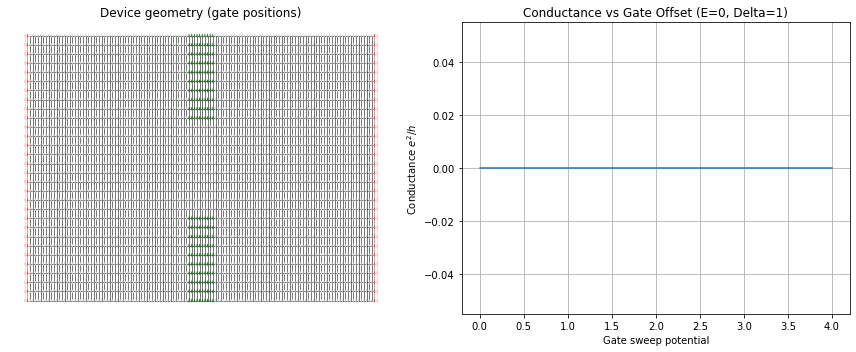

Staircasiness scores:
  window_loss: 1
  L1_regularization: 0
  L2_regularization: 0
  window_histogram: 1e+04
  multiple_windows_histogram: 1e+04
  stair_loss_simple: 42.87


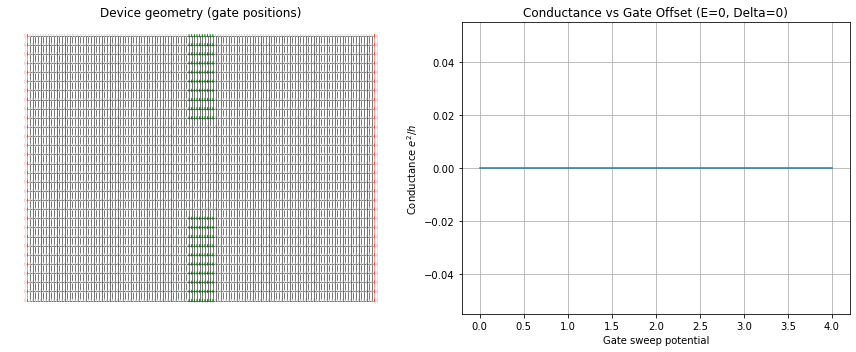

Staircasiness scores:
  window_loss: 1
  L1_regularization: 0
  L2_regularization: 0
  window_histogram: 1e+04
  multiple_windows_histogram: 1e+04
  stair_loss_simple: 42.87


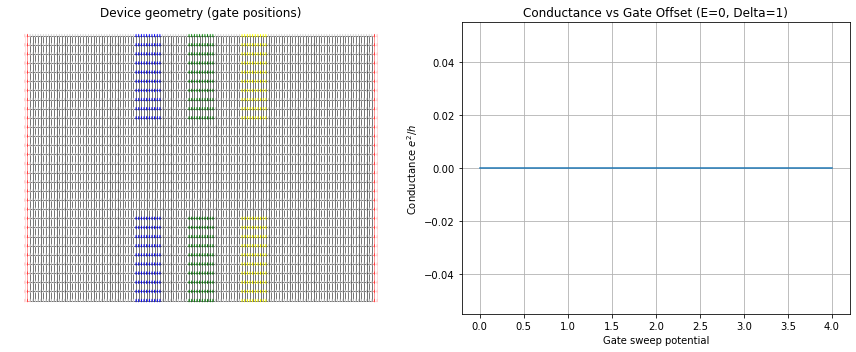

Staircasiness scores:
  window_loss: 1
  L1_regularization: 0
  L2_regularization: 0
  window_histogram: 1e+04
  multiple_windows_histogram: 1e+04
  stair_loss_simple: 42.87


In [17]:
config = [
        Gate((60,30),(60,20),(70,30),(70,20), 0, 5,'green'),
        Gate((60,10),(60,0),(70,10),(70,0), 0, 5,'green')
    ]

_, _, _, scores = run_simulation_and_score(config, device_height=30, device_length=130, Delta=1)

config = [
        Gate((60,30),(60,20),(70,30),(70,20), 0, 5,'green'),
        Gate((60,10),(60,0),(70,10),(70,0), 0, 5,'green')
    ]

_, _, _, scores = run_simulation_and_score(config, device_height=30, device_length=130, Delta=0)


config = [
        Gate((40,30),(40,20),(50,30),(50,20), 5, 5,'blue'),
        Gate((60,30),(60,20),(70,30),(70,20), 5, 5,'green',swept=True),
        Gate((80,30),(80,20),(90,30),(90,20), 5, 5,'yellow'),
        Gate((40,10),(40,0),(50,10),(50,0), 5, 5,'blue'),
        Gate((60,10),(60,0),(70,10),(70,0), 5, 5,'green', swept=True),
        Gate((80,10),(80,0),(90,10),(90,0), 5, 5,'yellow')
    ]

_, _, _, scores = run_simulation_and_score(config, device_height=30, device_length=130, Delta=1)